In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import glob
import matplotlib.pyplot as plt

In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio(
    "/content/drive/MyDrive/KLETECH/MiniProject/BrainTumourMRI_Images/Training",
   output="./dataset",
   seed=7,
   ratio=(0.8,0.1, 0.1)
)

Copying files: 2928 files [00:57, 50.81 files/s] 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
# Define your transform
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Define your train and test datasets and data loaders
train_dataset = datasets.ImageFolder('/content/dataset/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder('/content/dataset/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

val_dataset = datasets.ImageFolder('/content/dataset/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.7MB/s]


In [ ]:
num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Initialize empty lists to store the training and validation history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 50
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    for i, (images, labels) in enumerate(val_loader, 0):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss.item():.4f} - Train Accuracy: {accuracy:.2f}% - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/50] - Train Loss: 0.6615 - Train Accuracy: 63.39% - Val Loss: 6.0308 - Val Accuracy: 79.04%
Epoch [2/50] - Train Loss: 0.5072 - Train Accuracy: 82.14% - Val Loss: 4.1849 - Val Accuracy: 82.13%
Epoch [3/50] - Train Loss: 0.9861 - Train Accuracy: 84.37% - Val Loss: 3.5177 - Val Accuracy: 85.91%
Epoch [4/50] - Train Loss: 0.1867 - Train Accuracy: 86.97% - Val Loss: 3.8169 - Val Accuracy: 88.32%
Epoch [5/50] - Train Loss: 0.6097 - Train Accuracy: 89.45% - Val Loss: 4.2149 - Val Accuracy: 89.69%
Epoch [6/50] - Train Loss: 0.5308 - Train Accuracy: 89.41% - Val Loss: 2.5966 - Val Accuracy: 90.03%
Epoch [7/50] - Train Loss: 0.5146 - Train Accuracy: 90.18% - Val Loss: 3.0421 - Val Accuracy: 88.32%
Epoch [8/50] - Train Loss: 1.2551 - Train Accuracy: 91.24% - Val Loss: 2.9169 - Val Accuracy: 87.29%
Epoch [9/50] - Train Loss: 0.0889 - Train Accuracy: 92.61% - Val Loss: 3.5286 - Val Accuracy: 90.38%
Epoch [10/50] - Train Loss: 0.5840 - Train Accuracy: 92.74% - Val Loss: 2.9427 - Val Accura

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 94.59%


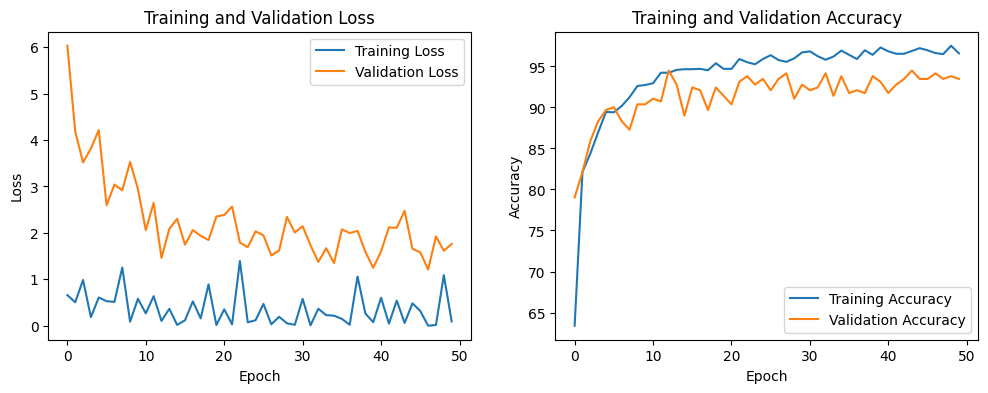

In [ ]:
import matplotlib.pyplot as plt

# After your training loop is complete and you have the lists train_losses, train_accuracies, val_losses, and val_accuracies

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 95.61%


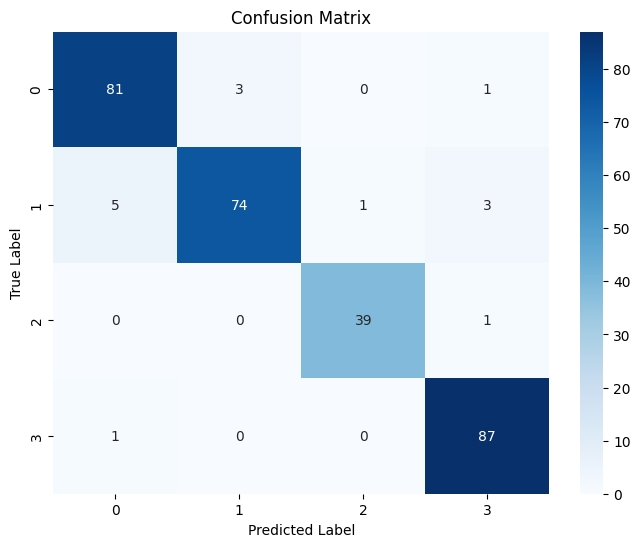

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to store the predicted and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Append the predicted and true labels to the lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:

# Define your transform
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assume you have DataLoader instances named train_loader, val_loader, and test_loader

# Define the CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CustomCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming you have DataLoader instances for train, val, and test sets
# Define the number of epochs
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize empty lists to store the training and validation history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    for i, (images, labels) in enumerate(val_loader, 0):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {loss.item():.4f} - Train Accuracy: {accuracy:.2f}% - "
          f"Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%")

# Test phase
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Epoch [1/50] - Train Loss: 0.8928 - Train Accuracy: 38.53% - Val Loss: 14.4656 - Val Accuracy: 51.55%
Epoch [2/50] - Train Loss: 1.0804 - Train Accuracy: 39.98% - Val Loss: 12.1573 - Val Accuracy: 50.86%
Epoch [3/50] - Train Loss: 1.3675 - Train Accuracy: 38.10% - Val Loss: 12.0983 - Val Accuracy: 49.48%
Epoch [4/50] - Train Loss: 1.3082 - Train Accuracy: 35.71% - Val Loss: 12.0266 - Val Accuracy: 40.55%
Epoch [5/50] - Train Loss: 0.9981 - Train Accuracy: 37.85% - Val Loss: 12.3233 - Val Accuracy: 43.30%
Epoch [6/50] - Train Loss: 1.2275 - Train Accuracy: 39.34% - Val Loss: 11.6624 - Val Accuracy: 47.77%
Epoch [7/50] - Train Loss: 1.6639 - Train Accuracy: 40.15% - Val Loss: 11.5805 - Val Accuracy: 51.89%
Epoch [8/50] - Train Loss: 1.2534 - Train Accuracy: 41.65% - Val Loss: 11.1799 - Val Accuracy: 52.92%
Epoch [9/50] - Train Loss: 1.5477 - Train Accuracy: 41.78% - Val Loss: 10.6875 - Val Accuracy: 57.73%
Epoch [10/50] - Train Loss: 1.2021 - Train Accuracy: 41.69% - Val Loss: 11.4203 - 

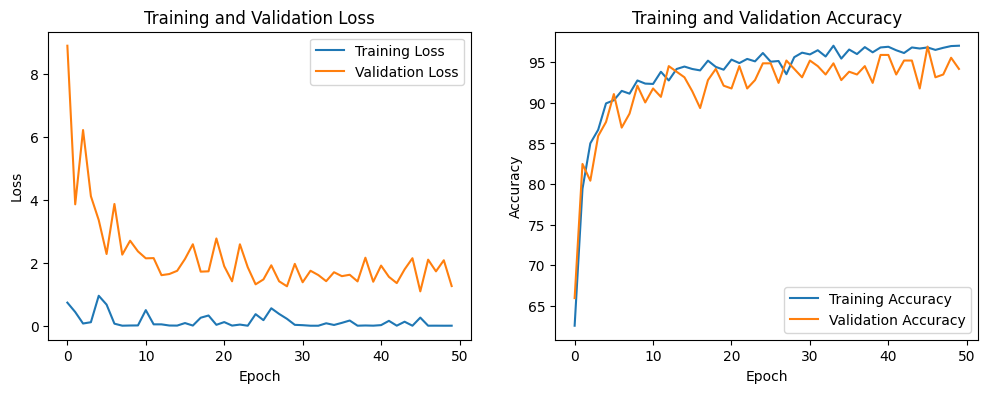

In [15]:
import matplotlib.pyplot as plt

# After your training loop is complete and you have the lists train_losses, train_accuracies, val_losses, and val_accuracies

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

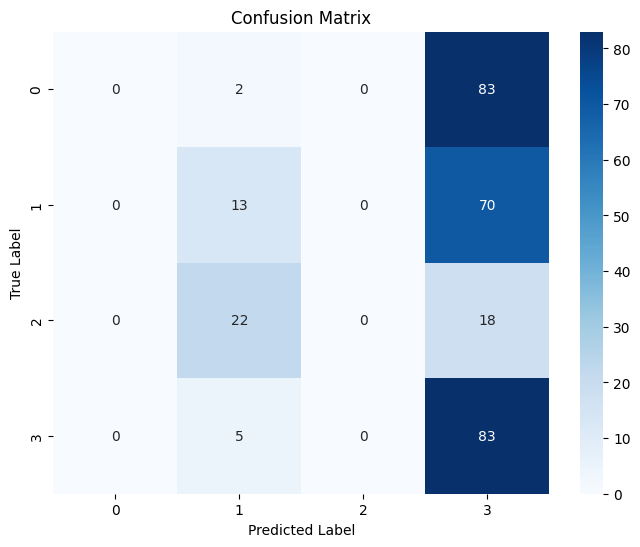

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to store the predicted and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Append the predicted and true labels to the lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, models

# Define your transform
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assume you have DataLoader instances named train_loader, val_loader, and test_loader

# Use the pre-trained VGG19 model from torchvision
model = models.vgg19(pretrained=True)

# Modify the fully connected layer for your number of classes
num_classes = 4
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Assuming you have DataLoader instances for train, val, and test sets
# Define the number of epochs
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize empty lists to store the training and validation history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    for i, (images, labels) in enumerate(val_loader, 0):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {loss.item():.4f} - Train Accuracy: {accuracy:.2f}% - "
          f"Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%")

# Test phase
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:14<00:00, 39.0MB/s]


Epoch [1/50] - Train Loss: 0.7350 - Train Accuracy: 62.58% - Val Loss: 8.9084 - Val Accuracy: 65.98%
Epoch [2/50] - Train Loss: 0.4362 - Train Accuracy: 79.41% - Val Loss: 3.8619 - Val Accuracy: 82.47%
Epoch [3/50] - Train Loss: 0.0702 - Train Accuracy: 85.01% - Val Loss: 6.2258 - Val Accuracy: 80.41%
Epoch [4/50] - Train Loss: 0.1116 - Train Accuracy: 86.67% - Val Loss: 4.1204 - Val Accuracy: 85.91%
Epoch [5/50] - Train Loss: 0.9533 - Train Accuracy: 89.92% - Val Loss: 3.3609 - Val Accuracy: 87.63%
Epoch [6/50] - Train Loss: 0.6719 - Train Accuracy: 90.30% - Val Loss: 2.2815 - Val Accuracy: 91.07%
Epoch [7/50] - Train Loss: 0.0653 - Train Accuracy: 91.46% - Val Loss: 3.8731 - Val Accuracy: 86.94%
Epoch [8/50] - Train Loss: 0.0011 - Train Accuracy: 91.11% - Val Loss: 2.2618 - Val Accuracy: 88.66%
Epoch [9/50] - Train Loss: 0.0069 - Train Accuracy: 92.74% - Val Loss: 2.7049 - Val Accuracy: 92.10%
Epoch [10/50] - Train Loss: 0.0094 - Train Accuracy: 92.35% - Val Loss: 2.3653 - Val Accura

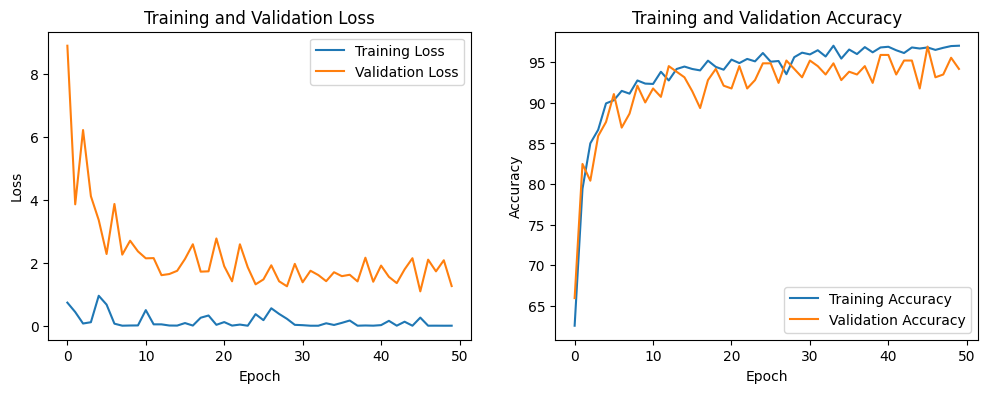

In [17]:
import matplotlib.pyplot as plt

# After your training loop is complete and you have the lists train_losses, train_accuracies, val_losses, and val_accuracies

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

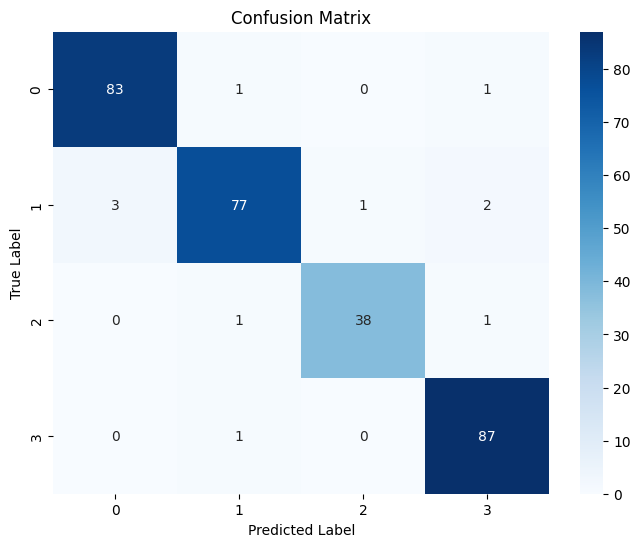

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to store the predicted and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Append the predicted and true labels to the lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()